In [1]:
import pandas as pd
import numpy as np
import openpyxl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Cross-sectional GSS data processing
# Load GSS overall data
gss = pd.read_excel("/Users/wooyongjung/WJ_Projects/LLM_POC_Study_2025_v2/data/GSS/GSS.xlsx")

# Create yearid by combining year and id
gss['yearid'] = gss['year'].astype(str) + "_" + gss['id_'].astype(str)

# Expect one row per respondent per wave, columns listed below:
BINARY_ITEMS = ["abdefect","abnomore","abany","abhlth","abpoor","abrape","absingle"]

# Map raw responses → 1/0 (edit as needed to match your GSS coding)
YES_VALUES = {"yes","Yes","YES",1, "1", True}
NO_VALUES  = {"no","No","NO",2, "2", False}

def to_binary(s):
    if pd.isna(s): return np.nan
    return 1 if s in YES_VALUES else (0 if s in NO_VALUES else np.nan)

def prepare_binary(df: pd.DataFrame) -> pd.DataFrame:
    out = df.copy()
    for col in BINARY_ITEMS:
        if col in out.columns:
            out[col+"_bin"] = out[col].apply(to_binary).astype("float")
    return out

# Following Rossi Scale

def collapse_abortion_attitudes(df: pd.DataFrame, id_col="yearid", binary_items=None):
    """
    Collapse 7 binary GSS abortion items (Rossi Scale) into a single 4-level categorical variable.
    
    - Input: df with columns abdefect ... absingle coded 0/1 (NaN allowed).
    - Output: df with new columns:
        'n_yes'  (count of yes across 7 items)
        'att4'   (collapsed attitude category)
    """
    out = df.copy()

    # Count number of "yes" responses (ignore NaN)
    out["n_yes"] = out[binary_items].sum(axis=1, skipna=True)

    # Count number of non-missing responses
    out["n_nonmiss"] = out[binary_items].notna().sum(axis=1)

    # Map counts into categories
    def map_to_cat(n_yes):
        if pd.isna(n_yes):
            return np.nan
        n_yes = int(n_yes)
        if n_yes <= 1:
            return "strong_anti"
        elif n_yes <= 3:
            return "anti"
        elif n_yes <= 6:
            return "pro"
        else:  # n_yes == 7
            return "strong_pro"

    out["abortion_att4"] = out["n_yes"].apply(map_to_cat)

    return out[[id_col, "year", "n_yes", "n_nonmiss", "abortion_att4"]]


# Construct binary items and collapse into attitude categories
gss_abt_bin = prepare_binary(gss)
gss_abt_bin = collapse_abortion_attitudes(gss_abt_bin, binary_items=[col+"_bin" for col in BINARY_ITEMS])

# Required columns (demographic) from gss_2020
required_columns = ["cohort", "degree", "race", "sex", "polviews", "natenvir", "trust", "homosex", "wtssps"] # exclude relig, marital (no data for GSS 2024)

# Merge demographic columns
gss_abt_cs = gss_abt_bin.merge(gss[required_columns + ["yearid"]], on="yearid", how="left")

# Create generation column based on birth year
def determine_generation(year):
    if pd.isna(year):
        return None
    elif year.startswith('.'):
        return None
    year = int(year)
    if year <= 1945:
        return "Silent Generation"
    elif 1946 <= year <= 1964:
        return "Baby Boomer"
    elif 1965 <= year <= 1980:
        return "Generation X"
    elif 1981 <= year <= 1996:
        return "Millennial"
    elif 1997 <= year <= 2012:
        return "Generation Z"
    else:
        return "Generation Alpha"

gss_abt_cs['generation'] = gss_abt_cs['cohort'].apply(determine_generation)


# Create education level column
def categorize_education(edu):
    if pd.isna(edu):
        return None
    elif edu in ["Less than high school", "High school"]:
        return "Less or equal to high school"
    elif edu in ["Associate/junior college", "Bachelor's"]:
        return "Associate or Bachelor's Degree"
    elif edu in ["Graduate"]:
        return "Graduate Degree"
    else:
        return None 

gss_abt_cs['edu_level'] = gss_abt_cs['degree'].apply(categorize_education)

# Create gender column
def categorize_gender(gender):
    if pd.isna(gender):
        return None
    elif gender == "MALE":
        return "Male"
    elif gender == "FEMALE":
        return "Female"
    else:
        return "Other"

gss_abt_cs['gender'] = gss_abt_cs['sex'].apply(categorize_gender)

# Create race column
def categorize_race(race):
    if pd.isna(race):
        return None
    elif race == "White":
        return "White"
    elif race == "Black":
        return "Black"
    elif race == "Other":
        return "Other"
    else:
        return None

gss_abt_cs['race'] = gss_abt_cs['race'].apply(categorize_race)

# # Create religion column
# def categorize_religion(relig):
#     if relig in ["Protestant", "Catholic", "None"]:
#         return relig
#     elif pd.isna(relig):
#         return None
#     else:
#         return "Other"

# gss_abt_cs['religion'] = gss_abt_cs['relig'].apply(categorize_religion)

# Create political views column
def categorize_political_views(pv):
    if pd.isna(pv):
        return None
    elif pv in ["Extremely liberal", "Liberal", "Slightly liberal"]:
        return "Liberal"
    elif pv in ["Moderate, middle of the road"]:
        return "Moderate"
    elif pv in ["Slightly conservative", "Conservative", "Extremely conservative"]:
        return "Conservative"
    else:
        return None

gss_abt_cs['political_views'] = gss_abt_cs['polviews'].apply(categorize_political_views)


# Create environmental attitude column
def categorize_environmental_attitude(env):
    if pd.isna(env):
        return None
    if env in ["TOO LITTLE"]:
        return "too_little"
    elif env in ["ABOUT RIGHT"]:
        return "about_right"
    elif env in ["TOO MUCH"]:
        return "too_much"
    else:
        return None
    
gss_abt_cs['natenvir'] = gss_abt_cs['natenvir'].apply(categorize_environmental_attitude)

# Create trust other people column
def categorize_trust(trust):
    if pd.isna(trust):
        return None
    if trust in ["Most people can be trusted"]:
        return "trust"
    elif trust in ["Can't be too careful"]:
        return "distrust"
    elif trust in ["Depends"]:
        return "depends"
    else:
        return None

gss_abt_cs['trust'] = gss_abt_cs['trust'].apply(categorize_trust)

# Create homosexuality attitude column
def categorize_homosexuality_attitude(homosex):
    if pd.isna(homosex):
        return None
    if homosex in ["ALWAYS WRONG"]:
        return "always_wrong"
    elif homosex in ["ALMST ALWAYS WRG"]:
        return "almost_always_wrong"
    elif homosex in ["SOMETIMES WRONG"]:
        return "sometimes_wrong"
    elif homosex in ["NOT WRONG AT ALL"]:
        return "not_wrong_at_all"
    else:
        return None

gss_abt_cs['homosex'] = gss_abt_cs['homosex'].apply(categorize_homosexuality_attitude)

In [3]:
gss_abt_cs.head()

,yearid,year,n_yes,n_nonmiss,abortion_att4,cohort,degree,race,sex,polviews,natenvir,trust,homosex,wtssps,generation,edu_level,gender,political_views
0,2006_1,2006,3.0,6,anti,1956,High school,Black,FEMALE,Extremely liberal,too_little,distrust,always_wrong,0.505483,Baby Boomer,Less or equal to high school,Female,Liberal
1,2006_2,2006,0.0,0,strong_anti,1979,High school,Other,MALE,Slightly liberal,None,distrust,None,2.090907,Generation X,Less or equal to high school,Male,Liberal
2,2006_3,2006,0.0,0,strong_anti,1939,Less than high school,White,FEMALE,Conservative,about_right,distrust,None,1.448735,Silent Generation,Less or equal to high school,Female,Conservative
3,2006_4,2006,7.0,7,strong_pro,1956,High school,Black,FEMALE,Slightly liberal,None,depends,not_wrong_at_all,0.385372,Baby Boomer,Less or equal to high school,Female,Liberal
4,2006_5,2006,7.0,7,strong_pro,1986,High school,Black,MALE,Liberal,None,distrust,always_wrong,1.387133,Millennial,Less or equal to high school,Male,Liberal


In [4]:
gss_abt_cs.shape

(29189, 18)

In [7]:
# Find the proportion of each abortion attitude category by year
CATS = ["strong_anti", "anti", "pro", "strong_pro"]
HOMOSEX4 = ["always_wrong", "almost_always_wrong", "sometimes_wrong", "not_wrong_at_all"]
TRUST3 = ["trust", "depends", "distrust"]  # --- IGNORE ---
gss_abt_cs['wtssps'] = gss_abt_cs['wtssps'].astype(float)
gss_abt_cs.head()

def weighted_proportions(df: pd.DataFrame, group_cols, cat_col, weight_col, categories):
    """
    Calculate weighted proportions of categories within groups.
    
    Parameters:
    - df: Input DataFrame.
    - group_cols: List of columns to group by.
    - cat_col: Column containing categorical variable.
    - weight_col: Column containing weights.
    - categories: List of all possible categories in cat_col.
    
    Returns:
    - DataFrame with weighted proportions for each category within each group.
    """
    # Initialize a list to collect results
    results = []

    # Group by the specified columns
    grouped = df.groupby(group_cols)

    for group_values, group_df in grouped:
        total_weight = group_df[weight_col].sum()
        if total_weight == 0:
            continue  # Avoid division by zero

        # Calculate weighted counts for each category
        weighted_counts = group_df.groupby(cat_col)[weight_col].sum().reindex(categories, fill_value=0)

        # Calculate proportions
        proportions = (weighted_counts / total_weight).to_dict()

        # Create a result record
        record = {col: val for col, val in zip(group_cols, group_values)}
        record.update(proportions)
        results.append(record)

    return pd.DataFrame(results)

# Calculate weighted proportions of abortion attitudes by year and demographics
p_cs_abortion = weighted_proportions(
    gss_abt_cs.dropna(subset=["abortion_att4"]),
    group_cols=["year"],
    cat_col="abortion_att4",
    weight_col="wtssps",
    categories=CATS
)

p_cs_homosex = weighted_proportions(
    gss_abt_cs.dropna(subset=["homosex"]),
    group_cols=["year"],
    cat_col="homosex",
    weight_col="wtssps",
    categories=HOMOSEX4
)


In [8]:
p_cs_homosex.head()

,year,always_wrong,almost_always_wrong,sometimes_wrong,not_wrong_at_all
0,2006,0.556949,0.048803,0.066070,0.328178
1,2008,0.529430,0.030903,0.063164,0.376503
2,2010,0.450530,0.039484,0.083742,0.426244
3,2012,0.456490,0.029863,0.079175,0.434472
4,2014,0.397642,0.033462,0.073352,0.495544


In [6]:
p_cs.head()

,year,strong_anti,anti,pro,strong_pro
0,2006,0.658356,0.138894,0.068347,0.134403
1,2008,0.481731,0.205181,0.105510,0.207579
2,2010,0.505645,0.177932,0.122146,0.194277
3,2012,0.486757,0.189104,0.120804,0.203336
4,2014,0.460472,0.195973,0.110562,0.232994


In [10]:
p_cs_homosex['Wrong'] = p_cs_homosex['always_wrong'] + p_cs_homosex['almost_always_wrong'] + p_cs_homosex['sometimes_wrong']
p_cs_homosex['Not Wrong'] = p_cs_homosex['not_wrong_at_all']
p_cs_abortion['Pro-Choice'] = p_cs_abortion['pro'] + p_cs_abortion['strong_pro']
p_cs_abortion['Pro-Life'] = p_cs_abortion['anti'] + p_cs_abortion['strong_anti']

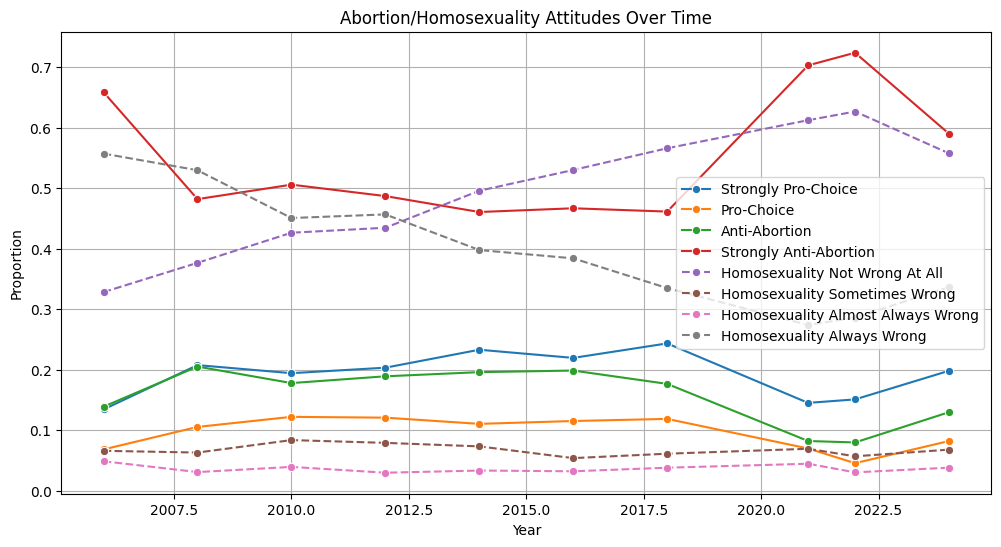

In [ ]:
# Make a plot of abortion and homosex attitudes over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=p_cs_abortion, x="year", y="strong_pro", label="Strongly Pro-Choice", marker="o")
sns.lineplot(data=p_cs_abortion, x="year", y="pro", label="Pro-Choice", marker="o")
sns.lineplot(data=p_cs_abortion, x="year", y="anti", label="Anti-Abortion", marker="o")
sns.lineplot(data=p_cs_abortion, x="year", y="strong_anti", label="Strongly Anti-Abortion", marker="o")
sns.lineplot(data=p_cs_homosex, x="year", y="not_wrong_at_all", label="Homosexuality Not Wrong At All", marker="o", linestyle="--")
sns.lineplot(data=p_cs_homosex, x="year", y="sometimes_wrong", label="Homosexuality Sometimes Wrong", marker="o", linestyle="--")
sns.lineplot(data=p_cs_homosex, x="year", y="almost_always_wrong", label="Homosexuality Almost Always Wrong", marker="o", linestyle="--")
sns.lineplot(data=p_cs_homosex, x="year", y="always_wrong", label="Homosexuality Always Wrong", marker="o", linestyle="--")
plt.title("Abortion/Homosexuality Attitudes Over Time")
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.legend()
plt.grid(True)
plt.show()

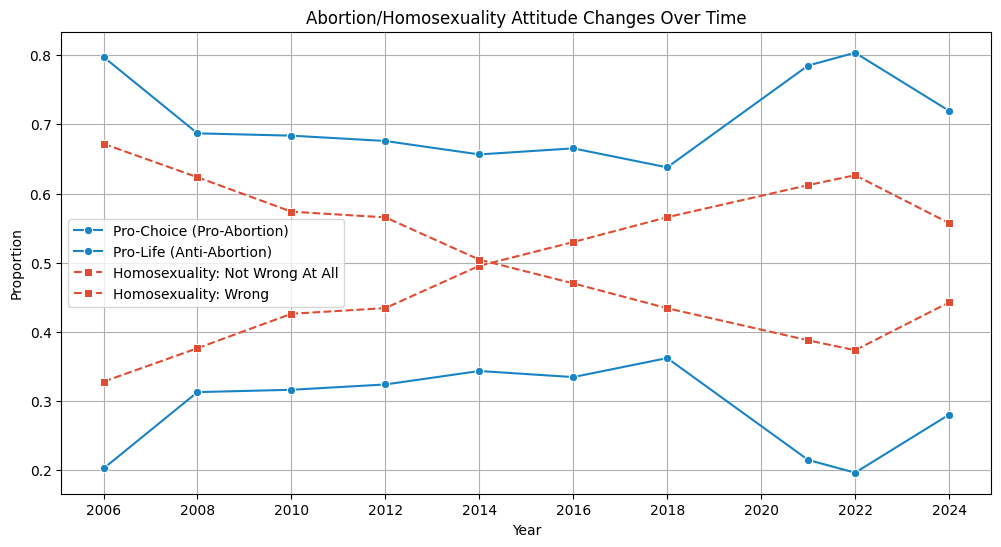

In [12]:
# Make a plot of abortion and homosex attitudes over time
plt.figure(figsize=(12, 6))
sns.lineplot(data=p_cs_abortion, x="year", y="Pro-Choice", label="Pro-Choice (Pro-Abortion)", marker="o", color='#1984c5')
sns.lineplot(data=p_cs_abortion, x="year", y="Pro-Life", label="Pro-Life (Anti-Abortion)", marker="o", color='#1984c5')
sns.lineplot(data=p_cs_homosex, x="year", y="Not Wrong", label="Homosexuality: Not Wrong At All", marker="s", linestyle="--", color="#e14b31")
sns.lineplot(data=p_cs_homosex, x="year", y="Wrong", label="Homosexuality: Wrong", marker="s", linestyle="--", color="#e14b31")
plt.title("Abortion/Homosexuality Attitude Changes Over Time")
plt.xlabel("Year")
plt.ylabel("Proportion")
plt.xticks(range(2006,2026,2))
plt.legend()
plt.grid(True)
plt.show()